<a href="https://colab.research.google.com/github/NavdeeepSinghh/-Assignment---4-/blob/main/Navdeep_singh_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchvision pandas numpy matplotlib seaborn scipy scikit-learn



In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [3]:

# Upload CSV to Colab
df = pd.read_csv("/content/data.csv", encoding='latin1')

x = df["no2"].dropna().values.astype(np.float32)

/tmp/ipython-input-252897137.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv", encoding='latin1')


In [4]:


# Log transform to handle heavy tail
x = np.log1p(x)

# Normalize
x = (x - x.mean()) / x.std()


In [5]:


r = 102303787
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)
z = torch.tensor(z).view(-1, 1)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [8]:

device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=2e-4)
opt_D = optim.Adam(D.parameters(), lr=2e-4)

criterion = nn.BCELoss()
z = z.to(device)


In [9]:

epochs = 2000
batch_size = 256

for epoch in range(epochs):
    idx = torch.randint(0, z.size(0), (batch_size,))
    real = z[idx]

    # Train Discriminator
    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = criterion(D_real, torch.ones_like(D_real)) + \
             criterion(D_fake, torch.zeros_like(D_fake))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # Train Generator
    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise)
    loss_G = criterion(D(fake), torch.ones_like(D(fake)))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.3f} | G Loss: {loss_G.item():.3f}")

Epoch 0 | D Loss: 1.357 | G Loss: 0.645
Epoch 400 | D Loss: 1.117 | G Loss: 1.057
Epoch 800 | D Loss: 1.256 | G Loss: 0.830
Epoch 1200 | D Loss: 1.384 | G Loss: 0.686
Epoch 1600 | D Loss: 1.378 | G Loss: 0.689


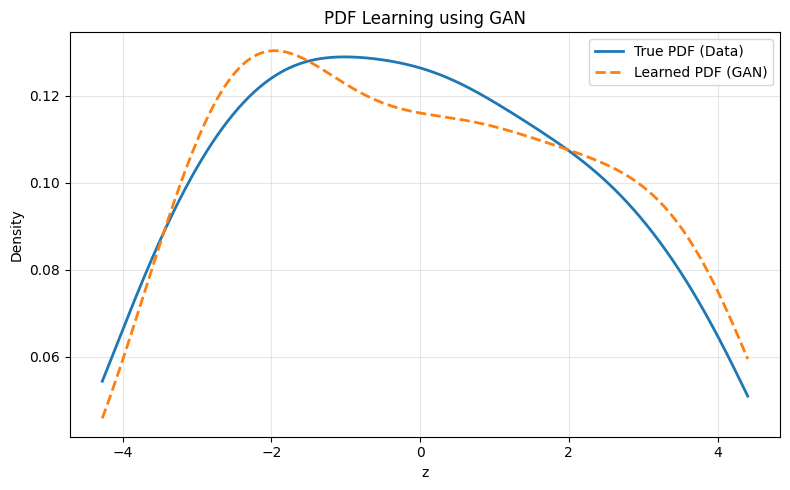

In [11]:
# Generate samples from trained GAN
with torch.no_grad():
    noise = torch.randn(15000, 1)
    z_fake = G(noise).cpu().numpy().flatten()

# Real samples(already numpy)
z_real = z.flatten()

# KDE-based PDF estimation
from scipy.stats import gaussian_kde

# KDE for real and generated data
kde_real = gaussian_kde(z_real, bw_method=0.4)
kde_fake = gaussian_kde(z_fake, bw_method=0.4)

# Range for plotting
xmin, xmax = np.percentile(z_real, [2, 98])
xs = np.linspace(xmin, xmax, 500)

# Plot smooth PDF curves
plt.figure(figsize=(8, 5))
plt.plot(xs, kde_real(xs), label="True PDF (Data)", linewidth=2)


plt.plot(xs, kde_fake(xs), linestyle="--", label="Learned PDF (GAN)", linewidth=2)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learning using GAN")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
